# Notes and References

Some articles I liked for theory behind Semantic Segmentation (SS):      
U-net SS: https://medium.datadriveninvestor.com/unet-for-semantic-segmentation-implementation-from-scratch-26e043fdcffa      
U-net SS: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47          
U-net SS: https://medium.com/@keremturgutlu/semantic-segmentation-u-net-part-1-d8d6f6005066           
Mask R-CNN: https://medium.com/analytics-vidhya/review-mask-r-cnn-instance-segmentation-human-pose-estimation-61080a93bf4    
Mask R-CNN: https://jonathan-hui.medium.com/image-segmentation-with-mask-r-cnn-ebe6d793272                    

I have learned a lot and copied snippets from the following notebooks:       
https://www.kaggle.com/bulentsiyah/deep-learning-based-semantic-segmentation-keras/notebook        
https://www.kaggle.com/kimchanyoung/implementation-of-mobileunet-in-tensorflow          
https://www.kaggle.com/sahintiryaki/brain-tumor-segmentation-vgg19-unet           
https://github.com/zhixuhao/unet             

Image Augmentation for Semantic Segmentation:     
https://idiotdeveloper.com/data-augmentation-for-semantic-segmentation-deep-learning/          
module used for image augmentation: https://github.com/albumentations-team/albumentations         

# Preprocessing

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import random
import math

import glob
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip, RandomCrop
from tqdm import tqdm

from sklearn.model_selection import train_test_split

## Data Handling
* store filename of images and annotated labels/masks from dataset
* sort the file names to match original image to corresponding mask

In [2]:
images_folder_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
masks_folder_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'
images_folder = sorted(glob.glob(images_folder_path+'*.jpg'))
masks_folder = sorted(glob.glob(masks_folder_path+'*.png'))

## Data Augmentation
* there are a total of 400 images only
* after training using U-net model with VGG19 encoder, we can find that training is not improving much after 4-6 epochs
* this suggests adding augmentation data
* we can use https://github.com/albumentations-team/albumentations module to apply some augmentations
* `RandomCrop`, `HorizontalFlip`, `VerticalFlip`, `RandomRotate90` are used here to create additional augmentated dataset
    * additionally one can use various methods to blur the image, or add noise for augmentation
    * we can also add `GridDistortion` and `ShiftScaleRotate` for augmentation
    * `RGBShift` is not a good idea for augmentation background pixels (road, grass, trees) depend on color
* Original image size 6000x4000 is large for the compute and memory capacity of Kaggle (with GPU), hence resized to given H, W
* Original image along with augmentated images are stored in new images and masks folders

In [3]:
## Data Augmentation
## It was chosen the resolution of 1536x1024px keep the ratio of the original images (6000x4000px). 

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def augment_data(images, masks, save_path):
    H = 1024
    W = 1536
    for x,y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        image_name = name[0]
        image_extn = name[1]
        
        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]       
        
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (W, H))
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (W, H))
        
        aug = RandomCrop(int(3*H/4), int(3*W/4), always_apply=False, p=1.0)
        augmented = aug(image=x, mask=y)
        x1 = augmented["image"]
        y1 = augmented["mask"]

        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x2 = augmented["image"]
        y2 = augmented["mask"]

        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x3 = augmented["image"]
        y3 = augmented["mask"] 

        aug = RandomRotate90(p=1.0)
        augmented = aug(image=x, mask=y)
        x4 = augmented['image']
        y4 = augmented['mask']

        save_images = [x, x1, x2, x3, x4]
        save_masks = [y, y1, y2, y3, y4]       
        
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            
            tmp_img_name = f"{image_name}_{idx}.{image_extn}"
            tmp_msk_name = f"{mask_name}_{idx}.{mask_extn}" 
            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_msk_name)
            
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)
            idx+=1


print(f"Original images:  {len(images_folder)} - Original masks: {len(masks_folder)}")

create_dir("./new_data/images/")
create_dir("./new_data/masks/")
save_path = "./new_data/"
augment_data(images_folder, masks_folder, save_path)

images = sorted(glob.glob(os.path.join(save_path, "images/*")))
masks = sorted(glob.glob(os.path.join(save_path, "masks/*")))
print(f"Augmented images:  {len(images)} - Augmented masks: {len(masks)}")

Original images:  400 - Original masks: 400


100%|██████████| 400/400 [05:17<00:00,  1.26it/s]

Augmented images:  2000 - Augmented masks: 2000


## store images and labels/masks file paths into dataframe for easy train, val, test split
* we can store file paths of images and masks into df and then use `train_test_split` to get paths for train, test, val set
* since we are more interested in visualizing the result of the learned model, we can keep 85% dataset for training
* we can assign a higher percentage for validation than testing, since numerical performance on val dataset guide training

In [4]:
df = pd.DataFrame({'images':images, 'masks':masks})
img_train, img_test, mask_train, mask_test = train_test_split(df['images'], df['masks'], test_size=0.15, random_state=7)
img_val, img_test, mask_val, mask_test = train_test_split(img_test, mask_test, test_size=0.3, random_state=7)
print(len(img_train), len(img_val), len(img_test))

1700 210 90


### Visualization of Augmented Images and Masks
* lets visualize augmented images and masks to make sure that images and masks are as expected
* visualize random images and respective masks from training set

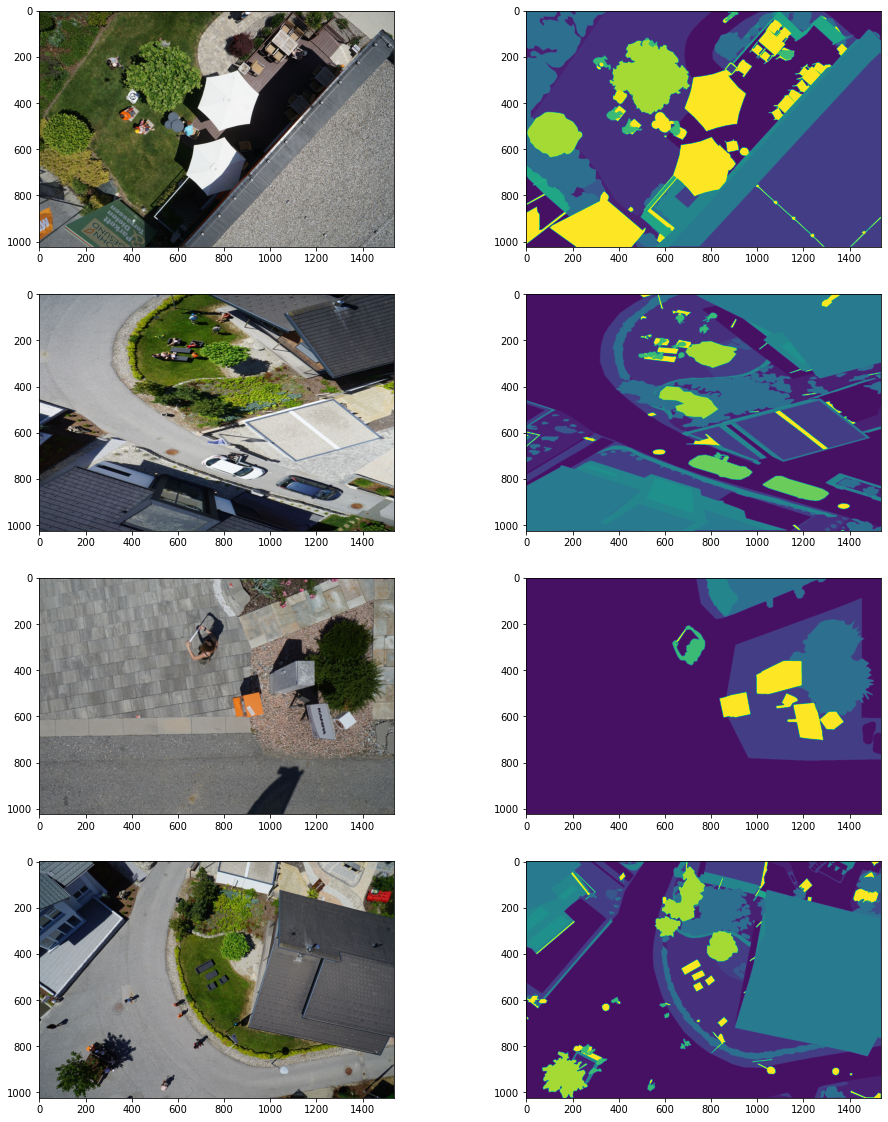

In [5]:
def visualize_img_mask(img_train, mask_train, k = 3):
    N = img_train.shape[0]
    fig, ax = plt.subplots(k, 2, figsize=(8*2, 5*k))
    for i,l in enumerate(random.sample(range(N), k)):
        img = img_train.iloc[l]
        mask = mask_train.iloc[l]
        ax[i,0].imshow(Image.open(img))
        ax[i,1].imshow(Image.open(mask))
        
visualize_img_mask(img_train, mask_train, k=4)

In [6]:
class_df = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv',index_col=False,skipinitialspace=True)
class_df

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


# Create Model

In [7]:
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')

import random

np.random.seed(7)
tf.random.set_seed(7)

## Image Resize for Training
* Ideally, training on same size image and mask as input will give better result
    * because of more pixel points, and hence resulting to *larger* dataset
* Due to the RAM and GPU compute limitation, images were resized with same height, width ratio
    * tried multiple values for height ranging above 600, with proportional width
    * all values for heights above 700 leads to memory error
    * height values ranging from 600 to 700 was resulting in model error
        * a difference of 1 in size tuple of `b1` and `s4` due to various convolutional methods
* Notice that one can use other pre-trained models as encoder like `VGG16`, `MobileNet`, etc.
    * For different encoders, one needs to define decoder accordingly
    * For different models, one can choose different height and width to optimize for corresponding compute
* One can use Google Colab for free GPU by importing the project from Kaggle to Google Colab
    * though Google Colab does not seem to provide more compute in terms of GPU and CPU, Colab compute varies
* Some resources to compare/check resources for Kaggle vs Colab
    * https://towardsdatascience.com/kaggle-vs-colab-faceoff-which-free-gpu-provider-is-tops-d4f0cd625029      
    * https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 
    * https://blog.paperspace.com/best-google-colab-alternatives/  

In [8]:
n_classes = 23
H = 512    
W = H*6//4   # to keep the H:W ratio equal to 4000:6000 <- the original ratio

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(n_classes, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_vgg19_unet((H,W,3))
model.summary()

2021-11-08 23:15:40.614892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 23:15:40.731840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 23:15:40.732545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 23:15:40.733649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 768, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 768, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 384, 64) 0           block1_conv2[0][0]               
_______________________

## Functions to prepare dataset into batches for model fit
* Function `tf_dataset` to prepare dataset into batches for model fit
* functions `read_image`, and `read_mask` to take path of image and mask and convert into array

In [9]:
## Dataset Pipeline used for training the model

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, n_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, n_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

## Creating Callbacks and Training the Model
* `ModelCheckpoint` callback to store model locally
* `ReduceLROnPlateau` to reduce learning rate when training reaches a plateau
* `EarlyStopping` to stop early (to avoid overfitting)

## Batch size selection
* a `batch_size` of value 8, 16, or 32 would be better 
    * but increasing batch size to even 5 or 6 was resulting into memory error on CUDA (GPU) or RAM memory
    * with a larger compute, one should choose a `batch_size` of 8, 16 or 32 
        * to get a smoother training loss and accuracy curve
        * overall slight performance improvement

In [10]:
checkpointer = [
    ModelCheckpoint(filepath="./model.h5",monitor='val_loss',verbose=2,save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=8, verbose=2, min_delta=1e-4)
]

batch_size = 4
train_dataset = tf_dataset(img_train, mask_train, batch=batch_size)
val_dataset = tf_dataset(img_val, mask_val, batch=batch_size)

train_steps = len(img_train)//batch_size
val_steps = len(img_val)//batch_size

In [11]:
num_epochs = 50
start_time = time.time()
history = model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=val_dataset, validation_steps=val_steps, epochs=num_epochs, callbacks=checkpointer)
end_time = time.time()
print(f"Time-taken for training: {(end_time-start_time)/60 : .3f} min")
print(f"approx. train-time for each epoch: {(end_time-start_time)/(60*num_epochs) : .3f}")

2021-11-08 23:15:44.921234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-08 23:15:48.788030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


425/425 [==============================] - 340s 761ms/step - loss: 1.3164 - accuracy: 0.6253 - val_loss: 1.2764 - val_accuracy: 0.6394

Epoch 00001: val_loss improved from inf to 1.27639, saving model to ./model.h5
Epoch 2/50
425/425 [==============================] - 324s 762ms/step - loss: 1.0372 - accuracy: 0.6885 - val_loss: 2.1178 - val_accuracy: 0.3749

Epoch 00002: val_loss did not improve from 1.27639
Epoch 3/50
425/425 [==============================] - 322s 759ms/step - loss: 0.9484 - accuracy: 0.7144 - val_loss: 1.4641 - val_accuracy: 0.5899

Epoch 00003: val_loss did not improve from 1.27639
Epoch 4/50
425/425 [==============================] - 323s 760ms/step - loss: 0.8830 - accuracy: 0.7355 - val_loss: 0.8824 - val_accuracy: 0.7442

Epoch 00004: val_loss improved from 1.27639 to 0.88238, saving model to ./model.h5
Epoch 5/50
425/425 [==============================] - 323s 761ms/step - loss: 0.8050 - accuracy: 0.7592 - val_loss: 0.8850 - val_accuracy: 0.7157

Epoch 00005:

Plots for Loss and Accuracy of training:


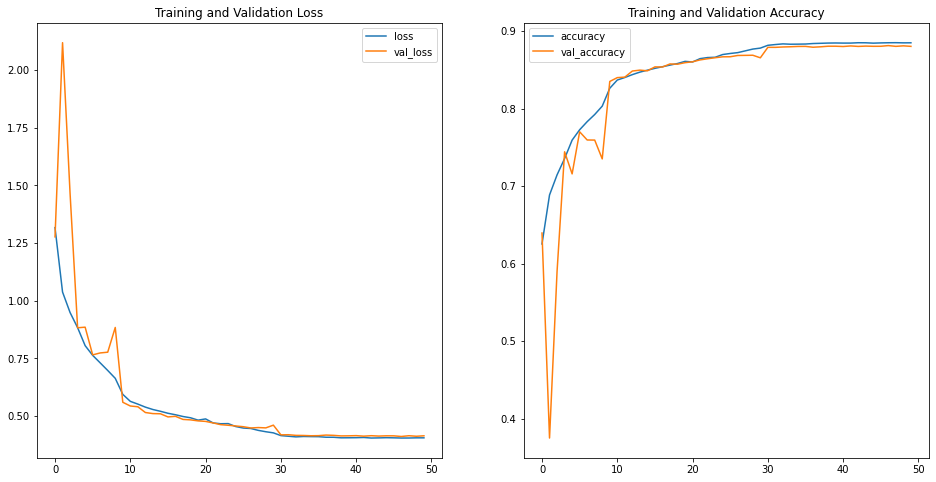

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()
ax[0].set_title('Training and Validation Loss')
ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].legend()
ax[1].set_title('Training and Validation Accuracy')
print('Plots for Loss and Accuracy of training:')

In [13]:
model_loaded = tf.keras.models.load_model('./model.h5')

# Visualize performance of trained model on unseen test set

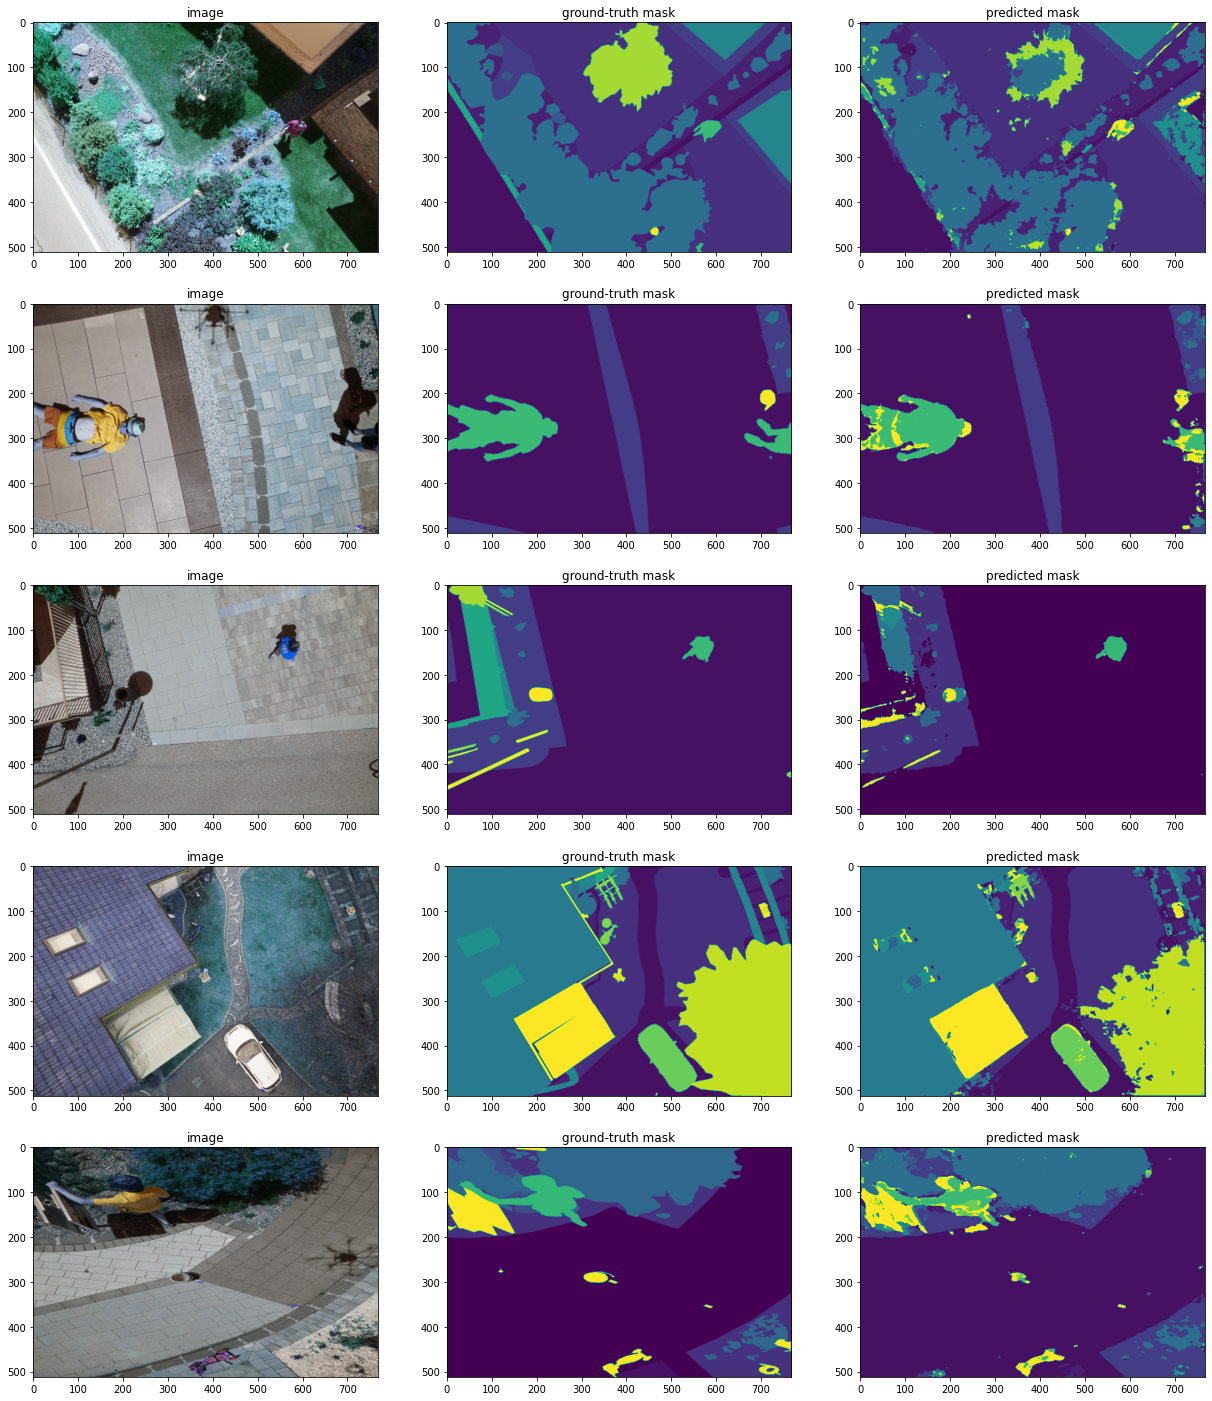

In [14]:
def visualize_predictions(img_test, mask_test, k = 3):
    N = img_test.shape[0]
    fig, ax = plt.subplots(k, 3, figsize=(7*3, 5*k))
    for i,l in enumerate(random.sample(range(N), k)):
        x = read_image(img_test.iloc[l])
        y = read_mask(mask_test.iloc[l])
        p = model_loaded.predict(x[np.newaxis, ...])[0]
        p = np.argmax(p, axis=-1)
        ax[i,0].imshow(x)
        ax[i,0].set_title('image')
        ax[i,1].imshow(y)
        ax[i,1].set_title('ground-truth mask')
        ax[i,2].imshow(p)
        ax[i,2].set_title('predicted mask')
        
visualize_predictions(img_test, mask_test, k=5)

# Measure changes in Model Encoder and Decoder weights
* For U-net, we starts with pre-trained weight of an encoder model; not the same for decoder model.
    * This makes sense as decoder learning is expected to depend more heavily on the type of masks/labels.
* For this section, I just wanted to check in the avg absolute weight difference in encoder and decoder layers.
* Result:
    * there is a gap between abs weight difference in encoder and decoder layers.
    * but weight difference in encoder layer is significant enough to not freeze these layers.
    * the pattern of values of these weights in corresponding layers is also interesting.

In [15]:
unlearned_model = build_vgg19_unet((H,W,3))

j = 0
print('Average Absolute Weight difference between Unlearned and Learned Models:')
print('Encoder Layers --------------------------------')
for um_layer, ml_layer in zip(unlearned_model.layers, model_loaded.layers):
    umw = um_layer.get_weights()
    mlw = ml_layer.get_weights()
    if 'transpose' in ml_layer.name and j == 0:
        print('Decoder Layers --------------------------------')
        j = 1
    if umw and mlw:
        wt0_num = np.array(umw[0].shape).sum()
        wt1_num = np.array(umw[1].shape).sum()
        um_ml_w0_diff = np.sum(np.abs(umw[0]-mlw[0]))
        um_ml_w1_diff = np.sum(np.abs(umw[1]-mlw[1]))
        print(f'{ml_layer.name:>25} --> {um_ml_w0_diff/wt0_num:7.2f}, {um_ml_w1_diff/wt1_num:5.2f}')

Average Absolute Weight difference between Unlearned and Learned Models:
Encoder Layers --------------------------------
             block1_conv1 -->    0.86,  0.15
             block1_conv2 -->    9.97,  0.02
             block2_conv1 -->   14.49,  0.03
             block2_conv2 -->   23.86,  0.05
             block3_conv1 -->   24.46,  0.03
             block3_conv2 -->   21.05,  0.03
             block3_conv3 -->   18.31,  0.02
             block3_conv4 -->   13.44,  0.01
             block4_conv1 -->    9.57,  0.00
             block4_conv2 -->   11.61,  0.00
             block4_conv3 -->    9.87,  0.00
             block4_conv4 -->   10.05,  0.00
             block5_conv1 -->    9.85,  0.00
             block5_conv2 -->   11.95,  0.00
             block5_conv3 -->   15.68,  0.00
             block5_conv4 -->   10.83,  0.00
Decoder Layers --------------------------------
         conv2d_transpose -->   30.48,  0.00
                   conv2d -->   67.20,  0.00
      batch_normaliza

# Future Steps

* References
    * https://towardsdatascience.com/review-segnet-semantic-segmentation-e66f2e30fb96
    * https://github.com/divamgupta/image-segmentation-keras
    * https://www.programmerall.com/article/46711017648/
    * https://stats.stackexchange.com/questions/252810/in-cnn-are-upsampling-and-transpose-convolution-the-same

* **Model Selection**  
    * We can try different pre-trained encoders like VGG16, MobileNet, ResNet-50, Vanilla CNN
* **Upsampling**, **Deconvolution**, **SegNet**
    * We can also try different Segmentation architectures e.g.
        * PSPNet, SegNet, Mask R-CNN
        * SegNet keeps track of pooling indices from encoder and use it during upsampling in corresponding decoder